## Task 1 - Zero-Shot Evaluation

In [2]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

In [8]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel, logging
from peft import LoraConfig, get_peft_model, TaskType
from torchinfo import summary
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import warnings

In [9]:
# some settings
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 32 # adjust based on your GPU memory
gradient_accumulation_steps = 1 # adjust based on your GPU memory
# For Linear Probe & LoRA
NUM_EPOCHS = 1
print(f"Using device: {DEVICE}")

In [10]:
# CLIP settings
# --- Load CLIP Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
# --- Define a transform to process images for CLIP ---
class CLIPTransform:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, image):
        # The processor expects a PIL image or list of images
        # It returns a dict, we extract 'pixel_values'
        # .squeeze(0) removes the batch dimension the processor adds
        return self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

clip_transform = CLIPTransform(processor)

In [11]:
# dataset related imports
from torchvision.datasets import Flowers102 
from datasets import load_dataset

# --- Flowers102 ---
# prepare Flowers102 dataset
flowers102_test_dts = Flowers102(root=".", split="test", transform=clip_transform) # evaluation on this set
print(f"Total test samples: {len(flowers102_test_dts)}") # should be 6149

# prepare class names for Flowers102
with open("cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)

flowers102_class_names = [cat_to_name[str(i + 1)] for i in range(102)]

# --- CUB-200-2011 ---
birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")
cub_bird_test_dts = birds_200["test"]
print(f"Total test samples: {len(cub_bird_test_dts)}") # should be 5794

# prepare class names for CUB-200-2011
cub_class_names_raw = birds_200["train"].features["label"].names
cub_class_names = [name.split('.')[-1].replace('_', ' ') for name in cub_class_names_raw]

# Wrap HF dataset to return (pixel_values, label) tensors compatible with default collate
class HFCUBWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_ds):
        self.hf_ds = hf_ds
    def __len__(self):
        return len(self.hf_ds)
    def __getitem__(self, idx):
        ex = self.hf_ds[idx]
        pv = clip_transform(ex["image"])  # Tensor [3, 224, 224]
        lbl = int(ex["label"])            # int
        return pv, lbl

cub_bird_test_wrapped = HFCUBWrapper(cub_bird_test_dts)

# === Create DataLoaders ===
flowers102_test_loader = DataLoader(flowers102_test_dts, batch_size=BATCH_SIZE, shuffle=False)
cub200_test_loader = DataLoader(cub_bird_test_wrapped, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
# Quick sanity check: fetch one batch to verify shapes
flowers_batch = next(iter(flowers102_test_loader))
print("Flowers batch pixel_values:", flowers_batch[0].shape, "labels:", flowers_batch[1].shape)

cub_batch = next(iter(cub200_test_loader))
print("CUB batch pixel_values:", cub_batch[0].shape, "labels:", cub_batch[1].shape)


In [13]:
print("--- Starting Method 1: Zero-Shot Classification ---")

# === 1. Load the full CLIP model ===
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval() # Set model to evaluation mode


In [ ]:

# === 2. Create and encode text prompts ===
def create_text_prompts(class_names, template):
    """Generates text prompts for all classes using a template."""
    prompts = [template.format(label=name) for name in class_names]
    return prompts


def encode_prompts(prompts, processor, model, device):
    """Tokenizes and encodes text prompts into feature vectors."""
    inputs = processor(text=prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    # Normalize features
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

# handcrafted prompts and custom prompts
# --- Flowers102 Prompts ---
flowers_template_base = "A photo of a {label}."
flowers_template_custom_1 = "A photo of a {label}, a type of flower."
flowers_template_custom_2 = "A botanical photo of a {label}."

flowers_prompts_base = create_text_prompts(flowers102_class_names, flowers_template_base)
flowers_prompts_custom_1 = create_text_prompts(flowers102_class_names, flowers_template_custom_1)
flowers_prompts_custom_2 = create_text_prompts(flowers102_class_names, flowers_template_custom_2)

flowers_text_features_base = encode_prompts(flowers_prompts_base, processor, model, DEVICE)
flowers_text_features_custom_1 = encode_prompts(flowers_prompts_custom_1, processor, model, DEVICE)
flowers_text_features_custom_2 = encode_prompts(flowers_prompts_custom_2, processor, model, DEVICE)

# --- CUB-200 Prompts ---
cub_template_base = "A photo of a {label}."
cub_template_custom_1 = "A photo of a {label}, a type of bird."
cub_template_custom_2 = "A bird species called {label}."

cub_prompts_base = create_text_prompts(cub_class_names, cub_template_base)
cub_prompts_custom_1 = create_text_prompts(cub_class_names, cub_template_custom_1)
cub_prompts_custom_2 = create_text_prompts(cub_class_names, cub_template_custom_2)

cub_text_features_base = encode_prompts(cub_prompts_base, processor, model, DEVICE)
cub_text_features_custom_1 = encode_prompts(cub_prompts_custom_1, processor, model, DEVICE)
cub_text_features_custom_2 = encode_prompts(cub_prompts_custom_2, processor, model, DEVICE)

print("Text prompts created and encoded.")

# === 3. Evaluate on the test set ===
def evaluate_zero_shot(dataloader, text_features, is_hf_dataset=False):
    """Performs zero-shot evaluation on a given dataloader and text features."""
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Zero-Shot Evaluation"):

            if is_hf_dataset:
                images = batch['pixel_values'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
            else:
                images, labels = batch
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

            # Get image features
            image_features = model.get_image_features(pixel_values=images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # --- Zero-shot classification ---
            # Cosine similarity as dot product (since features are normalized)
            logit_scale = model.logit_scale.exp()
            logits_per_image = logit_scale * image_features @ text_features.t()

            # Get predictions
            preds = torch.argmax(logits_per_image, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy, all_preds, all_labels

print("\nEvaluating Flowers102 (Base Prompt)...")
flowers_acc_base, flowers_preds_base, flowers_labels_base = evaluate_zero_shot(
    flowers102_test_loader, flowers_text_features_base, is_hf_dataset=False
)

print("Evaluating Flowers102 (Custom Prompt 1)...")
flowers_acc_custom_1, _, _ = evaluate_zero_shot(
    flowers102_test_loader, flowers_text_features_custom_1, is_hf_dataset=False
)

print("Evaluating Flowers102 (Custom Prompt 2)...")
flowers_acc_custom_2, _, _ = evaluate_zero_shot(
    flowers102_test_loader, flowers_text_features_custom_2, is_hf_dataset=False
)

print("\nEvaluating CUB-200 (Base Prompt)...")
# Our cub200_test_loader yields (pixel_values, label) tuples -> set is_hf_dataset=False
cub_acc_base, cub_preds_base, cub_labels_base = evaluate_zero_shot(
    cub200_test_loader, cub_text_features_base, is_hf_dataset=False
)

print("Evaluating CUB-200 (Custom Prompt 1)...")
cub_acc_custom_1, _, _ = evaluate_zero_shot(
    cub200_test_loader, cub_text_features_custom_1, is_hf_dataset=False
)

print("Evaluating CUB-200 (Custom Prompt 2)...")
cub_acc_custom_2, _, _ = evaluate_zero_shot(
    cub200_test_loader, cub_text_features_custom_2, is_hf_dataset=False
)

# === 4. Result Analysis ===

print("\n=== Zero-Shot Test Accuracy ===")
print("| Dataset | Oxford 102 | CUB-200 |")
print("|---------|-------------|---------|")
print(f"| Base   | {flowers_acc_base * 100:.2f}%     | {cub_acc_base * 100:.2f}%   |")
print(f"| Custom 1| {flowers_acc_custom_1 * 100:.2f}% | {cub_acc_custom_1 * 100:.2f}% |")
print(f"| Custom 2| {flowers_acc_custom_2 * 100:.2f}% | {cub_acc_custom_2 * 100:.2f}% |")

# also can do the "classification_report" and "confusion_matrix" here

# print("\nFlowers102 (Base) Classification Report:")
# print(classification_report(flowers_labels_base, flowers_preds_base, target_names=flowers_class_names, zero_division=0))
# print("\nCUB-200 (Base) Classification Report:")
# print(classification_report(cub_labels_base, cub_preds_base, target_names=cub_class_names, zero_division=0))

# === 5. Visualization ===
# use plt to visualize some predictions

def visualize_predictions(dataset, class_names, preds, labels, title, num_samples=4, is_hf_dataset=False):
    """Plots random samples with their true and predicted labels."""

    # We need a dataset instance *without* transforms to show the original PIL images
    if is_hf_dataset:
        viz_dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011")["test"]
    else:
        viz_dataset = Flowers102(root=".", split="test", transform=None, download=True)

    plt.figure(figsize=(16, 5))
    plt.suptitle(title, fontsize=16)

    # Get random indices
    indices = np.random.choice(len(preds), num_samples, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)

        if is_hf_dataset:
            img = viz_dataset[idx]['image']
            true_label_idx = viz_dataset[idx]['label']
            pred_label_idx = preds[idx]
        else:
            img, true_label_idx = viz_dataset[idx]
            pred_label_idx = preds[idx]

        true_label_name = class_names[true_label_idx]
        pred_label_name = class_names[pred_label_idx]

        plt.imshow(img)
        plt.axis('off')

        color = "green" if pred_label_idx == true_label_idx else "red"
        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}", color=color, fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Show visualizations ---
print("\nVisualizing predictions...")
visualize_predictions(
    flowers102_test_dts, flowers102_class_names, flowers_preds_base, flowers_labels_base,
    "Flowers102 Zero-Shot (Base Prompt)", is_hf_dataset=False
)

visualize_predictions(
    cub_bird_test_dts, cub_class_names, cub_preds_base, cub_labels_base,
    "CUB-200 Zero-Shot (Base Prompt)", is_hf_dataset=True
)


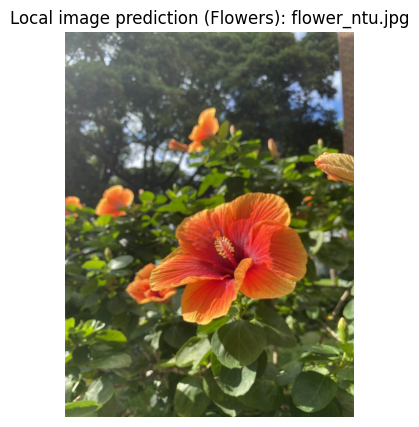

Top-5 predictions:
hibiscus                                  0.844
tree mallow                               0.061
trumpet creeper                           0.023
mallow                                    0.019
cape flower                               0.012


/tmp/ipykernel_3665049/794236141.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=probs, y=names, palette=palette)


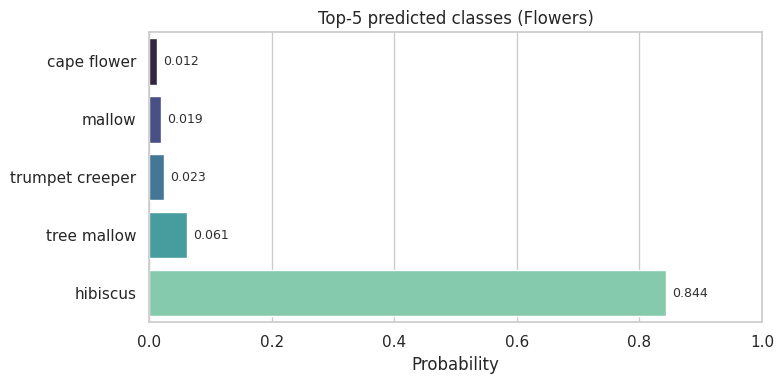

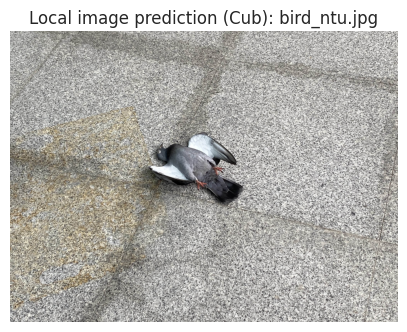

Top-5 predictions:
Chuck will Widow                          0.308
Sayornis                                  0.136
Worm eating Warbler                       0.071
Clay colored Sparrow                      0.066
Seaside Sparrow                           0.044


/tmp/ipykernel_3665049/794236141.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=probs, y=names, palette=palette)


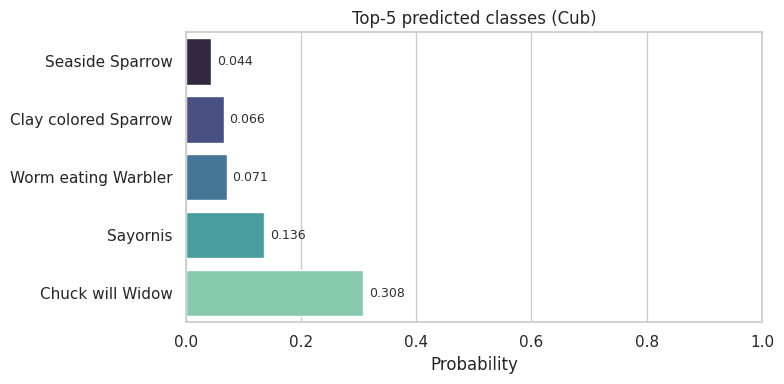

In [ ]:
# Try a local NTU photo (flower or bird)
from pathlib import Path
from PIL import Image


def predict_topk(image_path, class_names, template="A photo of a {label}.", top_k=5):
    """Predict top-k classes for a local image using zero-shot CLIP."""
    img = Image.open(image_path).convert("RGB")
    pixel_values = clip_transform(img).unsqueeze(0).to(DEVICE)  # [1, 3, 224, 224]

    # Build text features from prompt template
    prompts = [template.format(label=name) for name in class_names]
    text_inputs = processor(text=prompts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)

    with torch.no_grad():
        text_features = model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        image_features = model.get_image_features(pixel_values=pixel_values)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = model.logit_scale.exp() * (image_features @ text_features.T)  # [1, C]
        probs = logits.softmax(dim=-1).squeeze(0).cpu().numpy()

    top_idx = probs.argsort()[-top_k:][::-1]
    return [(class_names[i], float(probs[i])) for i in top_idx], img


def plot_topk_bar(topk, title="Top-k probabilities", palette="crest"):
    """Plot a pretty horizontal bar chart of top-k probabilities."""
    # topk is already sorted desc by prob; plot lowest at bottom -> reverse for nice stacking
    names = [n for n, _ in topk][::-1]
    probs = [p for _, p in topk][::-1]

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=probs, y=names, palette=palette)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Probability")
    ax.set_ylabel("")
    ax.set_title(title)
    # annotate probabilities at the end of bars
    for i, v in enumerate(probs):
        ax.text(min(v + 0.01, 0.98), i, f"{v:.3f}", va="center", ha="left", fontsize=9, color="#2f2f2f")
    plt.tight_layout()
    plt.show()


# Set these and run the cell
ntu_image_path = "img/flower_ntu.jpg"  # e.g., "/home/extra/aimmunder/aimmunder/CLIP/my_ntu_flower.jpg"
dataset = "flowers"  # "flowers" or "cub"
prompt_template = "A photo of a {label}."  # default CLIP template
TOP_K = 5

p = Path(ntu_image_path)
if p.is_file():
    if dataset.lower() == "flowers":
        class_names = flowers102_class_names
    elif dataset.lower() == "cub":
        class_names = cub_class_names
    else:
        raise ValueError("dataset must be either 'flowers' or 'cub'")

    topk, img = predict_topk(str(p), class_names, template=prompt_template, top_k=TOP_K)

    # Show image and predictions
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Local image prediction ({}): {}".format(dataset.title(), p.name))
    plt.show()

    print("Top-{} predictions:".format(TOP_K))
    for name, prob in topk:
        print(f"{name:40s}  {prob:.3f}")

    # Pretty probability bar chart
    plot_topk_bar(topk, title=f"Top-{TOP_K} predicted classes ({dataset.title()})", palette="mako")
elif ntu_image_path == "":
    print("Set ntu_image_path to a valid image file to run this test.")
else:
    print(f"Provided path is not a file: {ntu_image_path}")

# Example: switch to a bird photo
ntu_image_path = "img/bird_ntu.jpg"  # e.g., "/home/extra/aimmunder/aimmunder/CLIP/my_ntu_bird.jpg"
dataset = "cub"  # "flowers" or "cub"

p = Path(ntu_image_path)
if p.is_file():
    if dataset.lower() == "flowers":
        class_names = flowers102_class_names
    elif dataset.lower() == "cub":
        class_names = cub_class_names
    else:
        raise ValueError("dataset must be either 'flowers' or 'cub'")

    topk, img = predict_topk(str(p), class_names, template=prompt_template, top_k=TOP_K)

    # Show image and predictions
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Local image prediction ({}): {}".format(dataset.title(), p.name))
    plt.show()

    print("Top-{} predictions:".format(TOP_K))
    for name, prob in topk:
        print(f"{name:40s}  {prob:.3f}")
    # Pretty probability bar chart
    plot_topk_bar(topk, title=f"Top-{TOP_K} predicted classes ({dataset.title()})", palette="mako")
elif ntu_image_path == "":
    print("Set ntu_image_path to a valid image file to run this test.")
else:
    print(f"Provided path is not a file: {ntu_image_path}")
